In [2]:
import numpy as np
import matplotlib.pyplot as plt

import h5py

import sys
sys.path.append('../../')
import analysis_utils as utils
utils.load_plotting_setting()
import gas_likelihood_fit as fit
import calc_gas_collision_spectrum as gas

In [3]:
import importlib
importlib.reload(utils)
importlib.reload(fit)

<module 'gas_likelihood_fit' from '/Users/yuhan/work/nanospheres/gas_collisiions/analysis_notebooks/sphere_20260105/../../gas_likelihood_fit.py'>

In [11]:
eff_coefs = [2.88150446e+02, 1.08156304e-02]
eff_chi2  = 1
fit_band = (250, 400)
nll_offset = 0

sphere = 'sphere_20260105'
datasets_all = ['20260107_p8e_4e-8mbar', '20260107_p8e_3e-8mbar_valveclosed', 
                '20260107_p8e_5e-8mbar', '20260107_p8e_6e-8mbar', '20260107_p8e_8e-8mbar',
                '20260107_p8e_1e-7mbar', '20260107_p8e_2e-7mbar']
outfile_name = f'{sphere}_gas_recon_all.h5py'
outdir = r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/gas_recon'
out_dir = r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/likelihood_fit'

signal_file = r'/Users/yuhan/work/nanospheres/gas_collisiions/data_processed/gas_signal/xe_signal_5e-08nm_1e-08mbar.npz'
with np.load(signal_file) as f:
    alpha_list = f['alpha_list']
    ts_list = f['ts_list']
    qq_kev = f['qq_kev']
    drdqzs = f['drdqz']

In [12]:
def get_fitted_spectrum(sigma, log10_pressure, drdqz, bc, hist, eff_coefs, eff_chi2):
    log10_pressure_ref = -8
    pressure_scale = np.power(10, (log10_pressure - log10_pressure_ref))
    _, drdqzn = gas.smear_drdqz_gauss(qq_kev, drdqz, sigma)
    drdqzn_scaled = drdqzn * pressure_scale

    hist_norm = np.sum(hist) * fit.length_search_window * (bc[1] - bc[0])
    
    eff_qq = fit.func_eff(bc, *eff_coefs)
    hist_gas = eff_chi2 * eff_qq * drdqzn_scaled * hist_norm

    idx_fit = np.logical_and(bc > fit_band[0], bc < fit_band[1])
    bi = bc[idx_fit]
    ni = hist[idx_fit]

    gas_contribution = np.sum(hist_gas[idx_fit])
    ntot = np.sum(ni) - gas_contribution
    joint_pdf = fit.gaus_normalized(bi, 0, sigma, fit_band)

    mui = ntot * joint_pdf * 50 + hist_gas[idx_fit]

    return bi, mui, ni, ntot * joint_pdf * 50, hist_gas[idx_fit]

#### Read the likelihood fit

In [13]:
nlls_all_datasets = []
params_all_datasets = []
bestfit_params = []
for i in range(len(datasets_all)):
    outfile = f'{datasets_all[i]}_likelihood_fit.npz'

    with np.load(f'{out_dir}/{outfile}', 'r') as f:
        nlls_all = f['nlls_all']
        params_all = f['params_all']

        nlls_all_datasets.append(nlls_all)
        params_all_datasets.append(params_all)
    
    min_idx_flat = np.argmin(nlls_all)
    row, col = np.unravel_index(min_idx_flat, nlls_all.shape)
    bestfit_params.append(params_all[row][col])

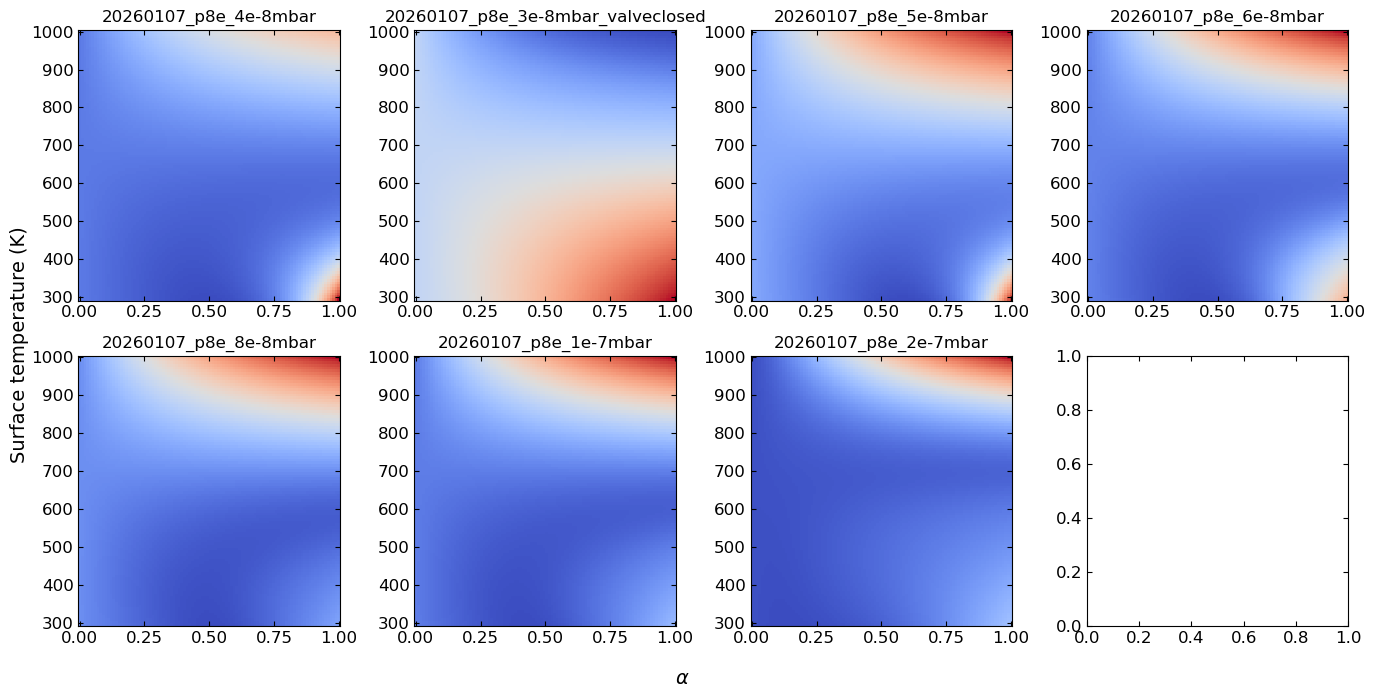

In [14]:
fig, axes = plt.subplots(2, 4, figsize=(14, 7))

for i in range(len(datasets_all)):
    ax = axes.flatten()[i]
    pcm = ax.pcolormesh(alpha_list, ts_list, (nlls_all_datasets[i]-np.min(nlls_all_datasets[i])).T, cmap='coolwarm')
    ax.set_title(datasets_all[i], fontsize=12)

fig.supxlabel(r'$\alpha$', fontsize=14)
fig.supylabel(r'Surface temperature (K)', fontsize=14)

fig.tight_layout()

Best fit $\alpha$/$T_s$: 0.49, 294.0 K


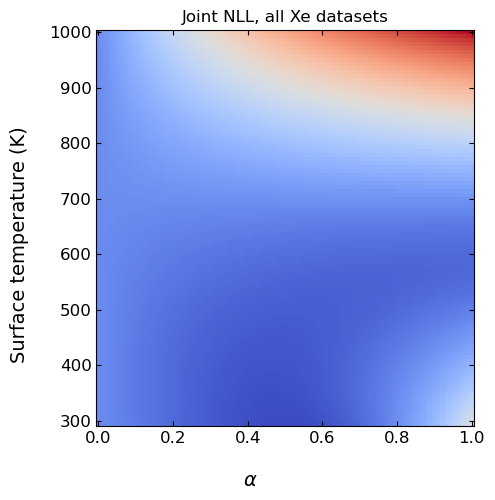

In [15]:
nlls_xe_all = np.sum(np.asarray([nlls_all_datasets[i] for i in [2, 3, 4, 5, 6]]), axis=0)

fig, ax = plt.subplots(figsize=(5, 5))

pcm = ax.pcolormesh(alpha_list, ts_list, (nlls_xe_all - np.min(nlls_xe_all)).T, cmap='coolwarm')
ax.set_title('Joint NLL, all Xe datasets', fontsize=12)

fig.supxlabel(r'$\alpha$', fontsize=14)
fig.supylabel(r'Surface temperature (K)', fontsize=14)

fig.tight_layout()

min_idx_flat = np.argmin(nlls_xe_all)
row, col = np.unravel_index(min_idx_flat, nlls_xe_all.shape)
print(fr'Best fit $\alpha$/$T_s$: {alpha_list[row]:.2f}, {ts_list[col]:.1f} K')

#### Another profile likelihood scan to determine the uncertainties of the fitted pressure 

In [21]:
sphere = 'sphere_20260105'
amp2kev = 6792.86423779262

def read_recon(file):
    f = h5py.File(file, 'r')
    try:
        pressure = f['data_processed'].attrs['pressure_mbar']

        amps = f['data_processed']['amplitude'][:]
        good_detection = f['data_processed']['good_detection'][:]
        noise_level_amp = f['data_processed']['noise_level_amp'][:]
        chi2 = f['data_processed']['chisquare'][:]
        f_res = f['data_processed']['f_res'][:]
        driven_power = f['data_processed']['driven_power'][:]

        f.close()

        return amps, good_detection, noise_level_amp, chi2, f_res, driven_power, pressure
    except:
        f.close()

def read_recon_all(dataset, type, file_prefix, nfiles):
    amps_all, good_detection_all, noise_level_all, chi2_all, driven_power_all, f_res_all, pressure_all = [], [], [], [], [], [], []
    for i in range(nfiles):
        file = rf'/Users/yuhan/work/nanospheres/data/gas_data_processed/{sphere}/{type}/{dataset}/{file_prefix}{i}_processed.hdf5'
        amps, good_detection, noise_level_amp, chi2, f_res, driven_power, pressure = read_recon(file)

        amps_all.append(amps)
        good_detection_all.append(good_detection)
        noise_level_all.append(noise_level_amp)
        chi2_all.append(chi2)
        driven_power_all.append(driven_power)
        f_res_all.append(f_res)
        pressure_all.append(pressure)

    return amps_all, good_detection_all, noise_level_all, chi2_all, driven_power_all, f_res_all, pressure_all

amps_0, good_detection_0, noise_level_0, chi2_0, driven_power_0, f_res_0, pressure_0 = read_recon_all('20260107_p8e_4e-8mbar', 'background_data', '20260107_df_', 150)
amps_1, good_detection_1, noise_level_1, chi2_1, driven_power_1, f_res_1, pressure_1 = read_recon_all('20260107_p8e_3e-8mbar_valveclosed', 'background_data', '20260107_df_', 150)

amps_2, good_detection_2, noise_level_2, chi2_2, driven_power_2, f_res_2, pressure_2 = read_recon_all('20260107_p8e_5e-8mbar', 'xenon_data', '20260107_df_', 150)
amps_3, good_detection_3, noise_level_3, chi2_3, driven_power_3, f_res_3, pressure_3 = read_recon_all('20260107_p8e_6e-8mbar', 'xenon_data', '20260107_df_', 150)
amps_4, good_detection_4, noise_level_4, chi2_4, driven_power_4, f_res_4, pressure_4 = read_recon_all('20260107_p8e_8e-8mbar', 'xenon_data', '20260107_df_', 150)
amps_5, good_detection_5, noise_level_5, chi2_5, driven_power_5, f_res_5, pressure_5 = read_recon_all('20260107_p8e_1e-7mbar', 'xenon_data', '20260107_df_', 150)
amps_6, good_detection_6, noise_level_6, chi2_6, driven_power_6, f_res_6, pressure_6 = read_recon_all('20260107_p8e_2e-7mbar', 'xenon_data', '20260107_df_', 150)

avg_pressures = np.asarray([np.mean(pressure_0), np.mean(pressure_1), np.mean(pressure_2), np.mean(pressure_3), np.mean(pressure_4), np.mean(pressure_5), np.mean(pressure_6)])

In [22]:
with h5py.File(f'{outdir}/{outfile_name}', 'r') as f:
    g = f['recon_histograms']
    bc = g['bc'][:]
    hh_0 = g[f'hist_{datasets_all[0]}'][:]
    hh_1 = g[f'hist_{datasets_all[1]}'][:]
    hh_2 = g[f'hist_{datasets_all[2]}'][:]
    hh_3 = g[f'hist_{datasets_all[3]}'][:]
    hh_4 = g[f'hist_{datasets_all[4]}'][:]
    hh_5 = g[f'hist_{datasets_all[5]}'][:]
    hh_6 = g[f'hist_{datasets_all[6]}'][:]

hist_all = [hh_0, hh_1, hh_2, hh_3, hh_4, hh_5, hh_6]

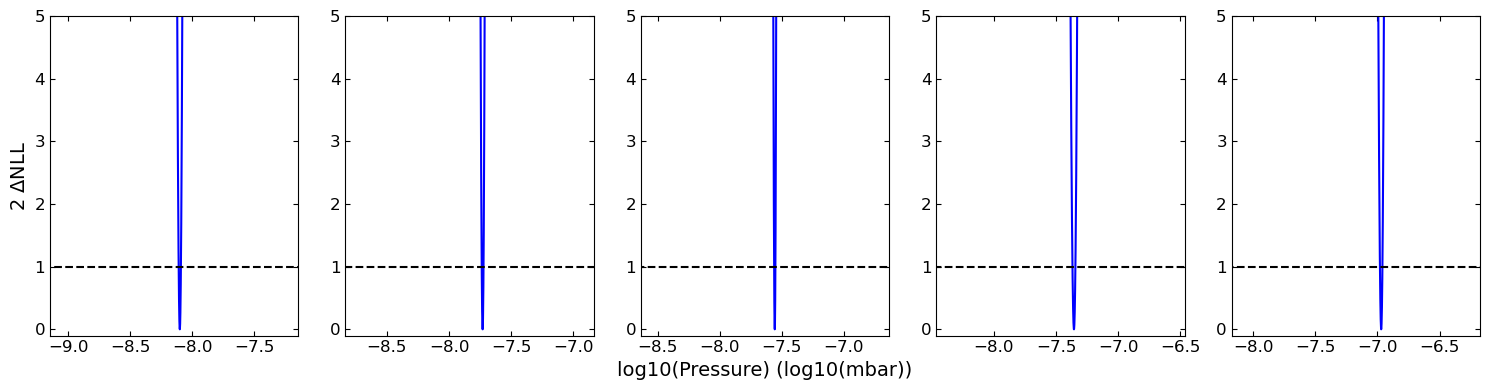

In [25]:
i = 6

fig, axes = plt.subplots(1, 5, figsize=(15, 4))\

best_logp_scan = np.empty(5)
logp_err = np.empty((5, 2))

for i in np.arange(2, 7, 1):
    sigma, log_p = np.asarray(bestfit_params[i])
    hist = hist_all[i]

    nll_all = nlls_all_datasets[i]
    min_idx_flat = np.argmin(nlls_all)
    row, col = np.unravel_index(min_idx_flat, nlls_all.shape)
    drdqz = drdqzs[row][col]

    log_p_list = np.concatenate([log_p-np.arange(0.25, 0.001, -0.001), log_p+np.arange(0, 0.25, 0.001)])
    _nlls = np.empty_like(log_p_list)
    for j, _logp in enumerate(log_p_list):
        _nlls[j] = fit.nll_sigma_pressure(sigma, _logp, drdqz, bc, hist, eff_coefs, eff_chi2, fit_band, nll_offset)

    idx_min = np.argmin(_nlls)
    best_logp_scan[i-2] = log_p_list[idx_min]

    lb = np.interp(_nlls[idx_min]+1, _nlls[0:idx_min], log_p_list[0:idx_min])
    ub = np.interp(_nlls[idx_min]+1, _nlls[idx_min:], log_p_list[idx_min:])
    logp_err[i-2] = np.asarray([lb, ub])

    axes[i-2].plot(log_p_list, 2*(_nlls - np.min(_nlls)), 'b')
    axes[i-2].hlines(1, -10, -6, color='k',linestyle='--')
    axes[i-2].set_xlim(log_p-1, log_p+1)

axes[2].set_xlabel('log10(Pressure) (log10(mbar))')
axes[0].set_ylabel(r'2 $\Delta$NLL')
for ax in axes:
    ax.set_ylim(-0.1, 5)
fig.tight_layout()
    

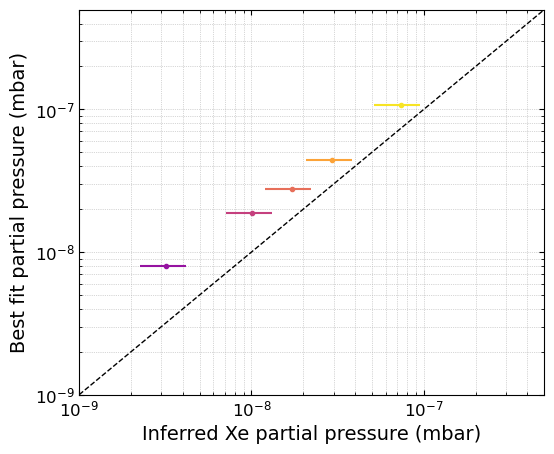

In [27]:
p_best = np.power(10, np.asarray(bestfit_params).T[1])
cmap = plt.colormaps.get_cmap('plasma')
colors = cmap(np.linspace(0, 0.95, 7))

fig, ax = plt.subplots(figsize=(6, 5))
for i in range(5):
    p_gauge_inferred = (avg_pressures[i+2] - avg_pressures[1]) * 0.4
    # ax.errorbar(p_gauge_inferred, p_best[i+2], xerr=p_gauge_inferred*0.3, fmt='.', color=colors[i+2])
    lb, ub = logp_err[i]
    ax.errorbar(p_gauge_inferred, 10**best_logp_scan[i], yerr=np.asarray([[10**best_logp_scan[i]-10**lb, 10**ub-10**best_logp_scan[i]]]).T, xerr=p_gauge_inferred*0.3, fmt='.', color=colors[i+2])    

ax.plot(np.logspace(-9, -6), np.logspace(-9, -6), 'k--', linewidth=1)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Inferred Xe partial pressure (mbar)')
ax.set_ylabel('Best fit partial pressure (mbar)')

ax.set_xlim(1e-9, 5e-7)
ax.set_ylim(1e-9, 5e-7)

ax.grid(which='both', ls=':', linewidth=0.5)

#### Plot the best fit spectra

/var/folders/mb/1ggr_wms5jz0l7fkkc3b9xg80000gn/T/ipykernel_7148/1238699998.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels([''])


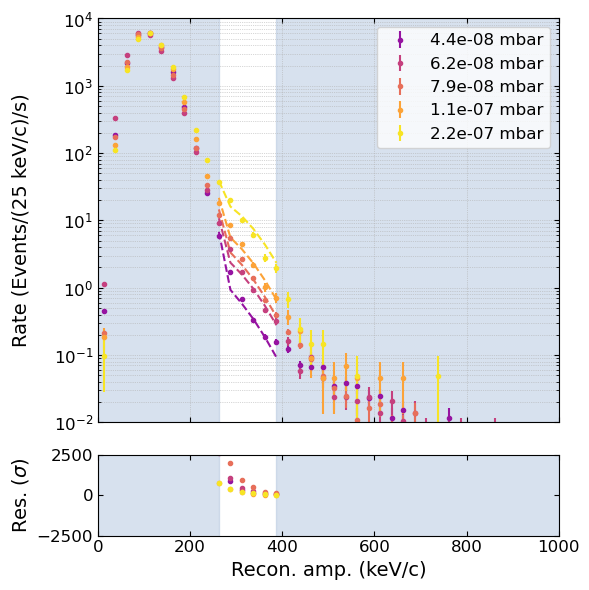

In [28]:
cmap = plt.colormaps.get_cmap('plasma')
colors = cmap(np.linspace(0, 0.95, 7))

fig, axes = plt.subplots(2, 1, figsize=(6, 6), height_ratios=[5, 1])

# ax.errorbar(bc, hh_0/(np.sum(hh_0)*50e-6), yerr=np.sqrt(hh_0)/(np.sum(hh_0)*50e-6),fmt='.', color=colors[0])

for i in range(5):
    hist = hist_all[i+2]
    nlls_all = nlls_all_datasets[i+2]
    sigma, log_p = np.asarray(bestfit_params[i+2])

    min_idx_flat = np.argmin(nlls_all)
    row, col = np.unravel_index(min_idx_flat, nlls_all.shape)

    # bi, mui, ni, gauss_i, gas_i = get_fitted_spectrum(sigma, log_p, drdqzs[row][col], bc, hist, eff_coefs, eff_chi2)
    bi, mui, ni, gauss_i, gas_i = get_fitted_spectrum(sigma, best_logp_scan[i], drdqzs[row][col], bc, hist, eff_coefs, eff_chi2)

    axes[0].errorbar(bc, hist/(np.sum(hist)*50e-6), yerr=np.sqrt(hist)/(np.sum(hist)*50e-6),fmt='.', color=colors[i+2], label=f'{avg_pressures[i+2]:.1e} mbar')
    axes[0].plot(bi, mui/(np.sum(hist)*50e-6), '--', color=colors[i+2])
    # ax.plot(bi, gas_i/(np.sum(hist)*50e-6), '--', color=colors[i+2])

    axes[1].plot(bi, ni-mui/np.sqrt(ni), '.', color=colors[i+2])

axes[0].fill_betweenx(np.logspace(-2, 4, 100), 0, fit_band[0]+12.5, color='#B0C4DE', alpha=0.5)
axes[0].fill_betweenx(np.logspace(-2, 4, 100), fit_band[1]-12.5, 1000, color='#B0C4DE', alpha=0.5)
axes[0].legend()

axes[0].set_yscale('log')
axes[0].set_ylim(1e-2, 1e4)
axes[0].grid(which='both', ls=':', linewidth=0.5)
axes[0].set_xticklabels([''])
axes[0].set_xlim(0, 1000)

axes[1].fill_betweenx(np.linspace(-5000, 5000, 500), 0, fit_band[0]+12.5, color='#B0C4DE', alpha=0.5)
axes[1].fill_betweenx(np.linspace(-5000, 5000, 500), fit_band[1]-12.5, 1000, color='#B0C4DE', alpha=0.5)
axes[1].set_xlim(0, 1000)
axes[1].set_ylim(-2500, 2500)

axes[1].set_xlabel('Recon. amp. (keV/c)')
axes[0].set_ylabel('Rate (Events/(25 keV/c)/s)')
axes[1].set_ylabel(r'Res. ($\sigma$)')

fig.align_labels()
fig.tight_layout()